In [1]:
import eli5
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from glob import glob
from IPython.display import display, Markdown
from ipywidgets import interact, fixed
from mlxtend.plotting import plot_decision_regions
from scipy.stats import percentileofscore
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels
from tqdm import tnrange, tqdm_notebook
from xgboost import XGBClassifier

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [3]:
# files = glob('LoanStats*.csv')

# def a_to_d_done(df):
#     a_to_d = df['grade'].isin(['A', 'B', 'C', 'D'])
#     done = df['loan_status'].isin(['Fully Paid', 'Charged Off'])
#     return a_to_d & done

# dfs = (pd.read_csv(file, skiprows=1, skipfooter=2, engine='python')
#        .where(a_to_d_done)
#        .dropna(subset=['grade', 'loan_status'])
#        for file in tqdm_notebook(files))

# df = pd.concat(dfs)

In [4]:
# historical, _ = train_test_split(df.copy(), train_size=0.10, 
#                              stratify=df['loan_status'])

In [5]:
# historical.to_csv('historical.csv', index=False)

In [6]:
df = pd.read_csv('data/historical.csv')
df.shape

(128334, 144)

In [7]:
current = pd.read_csv('data/primaryMarketNotes_browseNotes_1-RETAIL.csv')
current.shape

(58, 122)

In [8]:
common = set(df.columns) & set(current.columns)
hist = set(df.columns) - set(current.columns)
curr = set(current.columns) - set(df.columns)

In [9]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24000.0,24000.0,24000.0,36 months,11.48%,791.20,B,B5,captain,10+ years,MORTGAGE,85000.0,Verified,Jan-2016,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,853xx,AZ,33.60,0.0,Sep-1994,1.0,NaN,65.0,12.0,1.0,27828.0,85%,53.0,w,0.0,0.0,24555.220000,24555.22,24000.0,555.22,0.0,0.0,0.0,Mar-2016,23779.33,NaN,Aug-2017,0.0,74.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,371447.0,1.0,2.0,0.0,2.0,13.0,91449.0,83.0,2.0,5.0,7367.0,85.0,32850.0,2.0,7.0,3.0,8.0,30953.0,4179.0,94.0,0.0,0.0,168.0,256.0,5.0,5.0,4.0,7.0,NaN,3.0,NaN,0.0,7.0,9.0,12.0,13.0,29.0,9.0,19.0,9.0,12.0,NaN,0.0,0.0,3.0,98.0,85.7,0.0,0.0,397767.0,119277.0,29250.0,109901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,12000.0,12000.0,12000.0,36 months,14.33%,412.06,C,C2,"Demorizi & Polanco, M.D., P.A.",3 years,RENT,75000.0,Not Verified,Sep-2013,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,331xx,FL,9.06,0.0,Nov-1999,1.0,34.0,NaN,12.0,0.0,8060.0,57.2%,20.0,w,0.0,0.0,14289.000000,14289.00,12000.0,2289.00,0.0,0.0,0.0,Oct-2015,3623.68,NaN,Nov-2015,0.0,34.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,10107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14100.0,NaN,NaN,NaN,5.0,1123.0,1982.0,75.5,0.0,0.0,31.0,168.0,4.0,4.0,0.0,16.0,34.0,4.0,34.0,0.0,3.0,6.0,3.0,9.0,1.0,11.0,19.0,6.0,12.0,0.0,0.0,0.0,1.0,75.0,33.3,0.0,0.0,26380.0,10107.0,8100.0,12280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,25450.0,25450.0,25450.0,60 months,11.55%,560.36,B,B3,U.S. Army,10+ years,MORTGAGE,57000.0,Verified,Jul-2013,Fully Paid,n,NaN,Borrower added on 06/27/13 > I

In [10]:
current.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,accept_d,exp_d,list_d,credit_pull_d,review_status_d,review_status,url,desc,purpose,title,zip_code,addr_state,msa,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,mths_since_recent_inq,mths_since_recent_revol_delinq,mths_since_recent_bc,mort_acc,open_acc,pub_rec,total_bal_ex_mort,revol_bal,revol_util,total_bc_limit,total_acc,total_il_high_credit_limit,num_rev_accts,mths_since_recent_bc_dlq,initial_list_status,ils_exp_d,pub_rec_bankruptcies,num_accts_ever_120_pd,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,mths_since_last_major_derog,num_sats,num_tl_op_past_12m,mo_sin_rcnt_tl,tot_hi_cred_lim,tot_cur_bal,avg_cur_bal,num_bc_tl,num_actv_bc_tl,num_bc_sats,pct_tl_nvr_dlq,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_il_tl,mo_sin_old_il_acct,num_actv_rev_tl,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,effective_int_rate,application_type,disbursement_method,annual_inc_joint,dti_joint,verified_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mtg_payment,housing_payment,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,152167636,186565679,22000.0,19675.0,60,11.71,5.49,0.73,486.16,B,B3,NaN,< 1 year,MORTGAGE,60000.0,Not Verified,05-24-2019 06:08:38,07-07-2019 14:00:00,06-07-2019 14:00:00,05-21-2019 09:55:17,06-07-2019 10:00:50,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Credit card refinancing,Credit card refinancing,751xx,TX,NaN,0,2,13573,40.0,58.2,14.65,0,0.0,12-20-1999 16:00:00,665,669,1,52,,3,,2,5,9,0,21005,21005.0,54.6,32500,26,0,15,,f,NaN,0,0,0,0,0,NaN,9,2,2,103750,75437,8382,8,4,5,96,0,0,0,6,154,5,226,2,38500,5,8,989,11.60,INDIVIDUAL,DIRECT_PAY,,,,2,0,0,0,73,0.0,,2,2,9285.0,54.6,0,3,2,736.00,,,,,,,,,,,,,,
1,153003150,188095322,28000.0,26725.0,36,8.19,2.16,0.86,879.88,A,A4,NaN,< 1 year,RENT,80000.0,Not Verified,06-06-2019 21:39:53,07-07-2019 18:00:00,06-07-2019 18:00:00,06-04-2019 20:38:53,06-07-2019 13:56:56,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidation,Debt consolidation,921xx,CA,NaN,0,1,13197,75.0,71.0,32.19,0,0.0,09-04-2005 17:00:00,715,719,0,,,16,,40,0,14,0,135969,32303.0,71.0,45500,33,140166,12,,f,NaN,0,0,0,0,0,NaN,14,0,16,185666,135969,9712,12,7,8,100,0,0,0,21,156,7,165,40,45500,7,8,0,8.18,INDIVIDUAL,CASH,,,,0,6,0,1,16,103666.0,58.7,0,0,7843.0,63.0,1,2,0,0.00,,,,,,,,,,,,,,
2,152654206,187356227,27000.0,22500.0,36,10.33,5.15,1.01,875.41,B,B1,Logistics Manager,1 year,RENT,72000.0,Source Verified,06-05-2019 07:21:02,07-06-2019 10:00:00,06-06-2019 10:00:00,05-30-2019 04:47:10,06-06-2019 06:02:41,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Credit card refinancing,Credit card refinancing,480xx,MI,NaN,0,4,5880,40.0,75.0,21.38,0,0.0,02-27-2007 16:00:00,675,679,0,25,74,8,,22,0,10,1,35499,22028.0,54.9,23500,19,24193,10,,f,NaN,1,1,0,1,0,25.0,10,2,4,64293,35499,3550,5,3,5,94,0,0,0,9,110,4,147,4,40100,4,8,151,10.22,INDIVIDUAL,DIRECT_PAY,,,,1,2,1,2,7,13471.0,55.7,1,2,11381.0,55.2,1,1,2,0.00,,,,,,,,,,,,,,
3,152209289,186627083,40000.0,15725.0,36,25.00,12.86,1.42,1590.40,D,D4,NaN,3 years,MORTGAGE,9500.0,Verified,05-27-2019 08:52:04,07-08-2019 14:00:00,06-08-2019 14:00:00,05-21-2019 15:03:03,06-08-2019 09:57:43,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidatio

In [11]:
dic = pd.read_excel('data/LCDataDictionary.xlsx')
dic.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [12]:
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)
df['percent_paid'] = df['total_pymnt'] / df['funded_amnt']
df.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.545939,0.279100,0.0,0.327767,0.513106,0.745365,1.585171
Fully Paid,105857.0,1.146813,0.089585,1.0,1.083836,1.131872,1.195880,1.600152


Find baseline of expected value of random note choice.

In [13]:
def monte_carlo(n=10000,
                investment=1000,
                grades=['A', 'B', 'C', 'D'],
                start='2007-07-01',
                end='2019-03-01'):
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start) &
                 (df['issue_d'] <= end))
    
    notes = df[condition]
    
    sims = []
    
    for _ in tnrange(n):
        mine = notes.sample(investment // 25).copy()
        mine['paid'] = 25 * mine['percent_paid']
        gross = mine['paid'].sum()
        sims.append(gross)
        
    sims = pd.Series(sims)
    sns.distplot(sims)
    plt.axvline(x=investment)
    percent = percentileofscore(sims, investment)
    plt.title(f'{percent}% of sims did not profit.\nDates: {start} - {end}\nLoan Grades: {grades}')

In [14]:
# monte_carlo()

In [15]:
# monte_carlo(grades=['A'])

In [16]:
# monte_carlo(grades=['D'])

Make a model that does better!

In [17]:
features = list(common) + ['issue_d', 'percent_paid']
target = 'loan_status'
X = df[features]
y = df[target]

In [18]:
def train_val_test_split(X, 
                         y,
                         train_size=.8,
                         val_size=.1,
                         test_size=.1,
                         random_state=42,
                         shuffle=True):
    
    assert train_size + val_size + test_size == 1
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=test_size,
                                                              random_state=random_state,
                                                              shuffle=shuffle,
                                                              stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                      y_trainval,
                                                      test_size=val_size / (train_size + val_size),
                                                      random_state=random_state,
                                                      shuffle=shuffle,
                                                      stratify=y_trainval)
    print(f'X_train shape: {X_train.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_val shape: {y_val.shape}')
    print(f'y_test shape: {y_test.shape}')

    return X_train, X_val, X_test, y_train, y_val, y_test

In [19]:

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)


X_train shape: (102666, 104)
X_val shape: (12834, 104)
X_test shape: (12834, 104)
y_train shape: (102666,)
y_val shape: (12834,)
y_test shape: (12834,)


### Get bseline metrics for predicting the majority class.

In [20]:
y_train.value_counts(normalize=True)

Fully Paid     0.824859
Charged Off    0.175141
Name: loan_status, dtype: float64

In [21]:
majority = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority)
accuracy_score(y_val, y_pred)

0.824840268038024

In [22]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

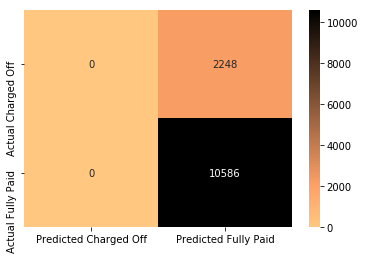

In [23]:
nice_confusion(y_val, y_pred);

In [24]:
print(classification_report(y_val, y_pred))

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      2248
  Fully Paid       0.82      1.00      0.90     10586

    accuracy                           0.82     12834
   macro avg       0.41      0.50      0.45     12834
weighted avg       0.68      0.82      0.75     12834



Predict 100% probability for majority class.

In [25]:
y_pred_proba = np.full_like(y_val, fill_value=1.0)
roc_auc_score(y_val, y_pred_proba)

0.5

In [26]:
y_pred_proba

array([1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0], dtype=object)

Any constant will result in a 0.5 roc_auc

### Get actual results of loans to compare with predictions.

In [27]:
columns = ['issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
results_train = X_train[columns].copy()
results_val = X_val[columns].copy()
results_test = X_test[columns].copy()

## Clean Data

There are lots of missing values

In [28]:
nulls = X_train.isnull().sum().sort_values(ascending=False)
nulls = nulls.index[:73].tolist()

In [29]:
def clean_it_up(data, high_nulls):
    df = data.copy()
    
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], infer_datetime_format=True)
    df['earliest_cr_line'] = df['issue_d'] - df['earliest_cr_line']
    df['earliest_cr_line'] = df['earliest_cr_line'].dt.days

    df['sec_app_earliest_cr_line'] = pd.to_datetime(df['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
    df['sec_app_earliest_cr_line'] = df['issue_d'] - df['sec_app_earliest_cr_line']
    df['sec_app_earliest_cr_line'] = df['sec_app_earliest_cr_line'].dt.days

    df['issue_d_year'] = df['issue_d'].dt.year
    df['issue_d_month'] = df['issue_d'].dt.month

    # Percentage strings -> float.
    df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['revol_util'] = df['revol_util'].str.strip('%').astype(float)
    
    # Make some employee categories.
    df['emp_title'] = df['emp_title'].str.lower()
    df['emp_teacher'] = df['emp_title'].str.contains('teacher', na=False)
    df['emp_nurse'] = df['emp_title'].str.contains('nurse|rn', na=False)
    df['emp_mid_manage'] = df['emp_title'].str.contains('manager|supervisor', na=False)
    df['emp_up_manage'] = df['emp_title'].str.contains('owner|director|president|officer|^c.o$')
    df['emp_title'] = df['emp_title'].str.len()
    
    df['desc'] = df['desc'].str.len()
    df['title'] = df['title'].str.len()
    
    # Columns with many NANs converted to binary.
    for col in high_nulls:
        df[col + '_NULL'] = df[col].isnull()
    
    # Drop columns.
    df = df.drop(columns=['id',
                          'member_id',
                          'grade',
                          'zip_code',
                          'issue_d',
                          'percent_paid',
                          'url'])
                          
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_teacher', 'emp_nurse', 'emp_mid_manage',
                'emp_up_manage', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']
    
#     # Impute mean for features with fewer NANs
#     for col in df:
#         if df[col].isnull().sum() > 0:
#             df[col] = df[col].fillna(df[col].mean())
    
    # Transform sub_grade to float ranking 1.1 -7.5
    def sub_grade(x):
        first = ord(x[0]) - 64
        last = int(x[1]) / 10
        return first + last
    
    df['sub_grade'] = df['sub_grade'].apply(sub_grade)

    df = df[features]
    
    return df


In [30]:
X_train = clean_it_up(X_train, nulls)
X_val = clean_it_up(X_val, nulls)
X_test = clean_it_up(X_test, nulls)

In [31]:
X_train.shape, X_val.shape, X_test.shape

((102666, 67), (12834, 67), (12834, 67))

Train a model.

In [32]:
processor = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(verbose=10))

X_train_ = processor.fit_transform(X_train)
X_val_ = processor.transform(X_val)
X_test_ = processor.transform(X_test)

print(X_train_.shape, X_val_.shape, X_test_.shape)

(102666, 67) (12834, 67) (12834, 67)


In [33]:
model = RandomForestClassifier(n_estimators=250,
                               n_jobs=-1, 
                               random_state=42)

model.fit(X_train_, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
# Accuracy score.
y_pred = model.predict(X_val_)
accuracy_score(y_val, y_pred)

0.8253856942496494

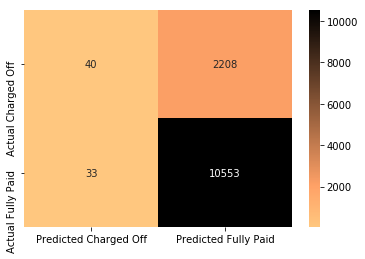

In [35]:
# Confusion matrix.
nice_confusion(y_val, y_pred);

In [36]:
# Precision and recall.
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.55      0.02      0.03      2248
  Fully Paid       0.83      1.00      0.90     10586

    accuracy                           0.83     12834
   macro avg       0.69      0.51      0.47     12834
weighted avg       0.78      0.83      0.75     12834



In [37]:
y_pred_proba = model.predict_proba(X_val_)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.698567545062202

Visulalize ROC curve.

In [38]:
def set_threshold(y_true, y_pred_proba, threshold):
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate}')
    print(f'False Positive Rate: {false_pos_rate}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba)}')
    
    nice_confusion(y_true, y_pred)
    print(classification_report(y_true, y_pred))


In [39]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Find feature importance and trim features.

In [40]:
%%time
imputer = PermutationImportance(model,
                                scoring='roc_auc',
                                cv='prefit',
                                n_iter=5,
                                random_state=42
                                )

imputer.fit(X_val_, y_val)

Wall time: 3min 48s


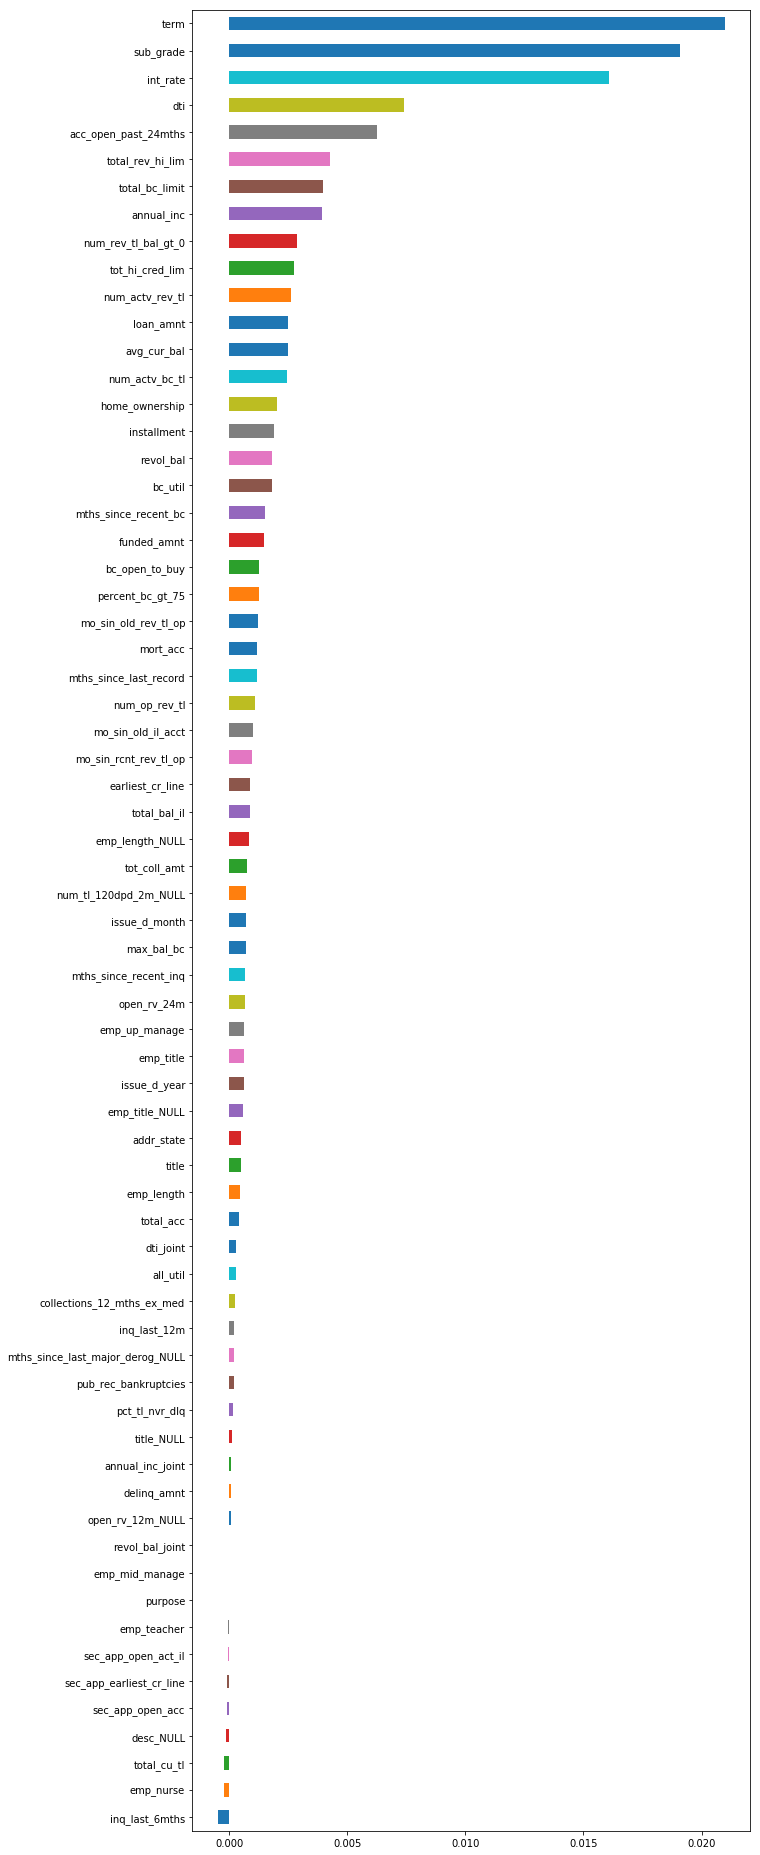

In [41]:
importance = pd.Series(imputer.feature_importances_, X_val.columns)
plt.figure(figsize=(10, len(X_val.columns.tolist()) / 2))
importance.sort_values(ascending=True).plot.barh();

In [42]:
mask = imputer.feature_importances_ > 0

features = X_train.columns[mask]
X_train_trimmed = X_train[features]
X_val_trimmed = X_val[features]
X_test_trimmed = X_test[features]

processor = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_t = processor.fit_transform(X_train_trimmed)
X_val_t = processor.transform(X_val_trimmed)
X_test_t = processor.transform(X_test_trimmed)

In [43]:
model = RandomForestClassifier(n_estimators=250,
                               n_jobs=-1,
                               random_state=42)
model.fit(X_train_t, y_train)
y_pred_proba = model.predict_proba(X_val_t)[:, 1]

In [44]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0, 1, 0.025));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.025), Output()), _dom_cl…

Expected value calculations.

In [45]:
def results(result_df, y_true, y_pred_proba):
    df = result_df.copy()
    df['loan_status'] = y_true
    df['pred_proba'] = y_pred_proba
    df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['term'] = df['term'].str.replace(r'\D', '').astype(int) / 12
    df['best_case'] = 25 * (1 + df['int_rate'] / 100)**df['term']
    df['worst_case'] = -25
    df['expected_value'] = (df['pred_proba'] * df['best_case'] +
                            (1 - df['pred_proba']) * df['worst_case']).astype(float)
    df['actual_return'] = (df['percent_paid'] * 25) - 25
    return df

In [46]:
val_result = results(results_val, y_val, y_pred_proba)

In [47]:
val_result.head()

,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
103402,2016-05-01,B,0.118710,3.0,9.16,Charged Off,0.920,32.518506,-25,27.917026,-22.032250
35754,2015-09-01,C,1.165141,5.0,12.69,Fully Paid,0.884,45.432528,-25,37.262355,4.128528
79613,2016-08-01,B,1.092054,5.0,10.49,Fully Paid,0.856,41.167536,-25,31.639411,2.301349
75206,2017-10-01,A,1.072000,3.0,7.21,Fully Paid,0.932,30.806751,-25,27.011892,1.799989
82007,2014-03-01,C,1.117542,5.0,13.65,Fully Paid,0.788,47.400968,-25,32.051963,2.938550


In [48]:
model = XGBClassifier(n_jobs=-1,
                      random_state=42)
eval_set = [(X_train_t, y_train),
            (X_val_t, y_val)]

model.fit(X_train_t,
          y_train,
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=50,
          verbose=0)

y_pred_proba = model.predict_proba(X_val_t)[:, 1]

In [49]:
val_result = results(results_val, y_val, y_pred_proba)

In [50]:
val_result.head(10)

,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
103402,2016-05-01,B,0.118710,3.0,9.16,Charged Off,0.902537,32.518506,-25,26.912566,-22.032250
35754,2015-09-01,C,1.165141,5.0,12.69,Fully Paid,0.831294,45.432528,-25,33.550121,4.128528
79613,2016-08-01,B,1.092054,5.0,10.49,Fully Paid,0.859241,41.167536,-25,31.853829,2.301349
75206,2017-10-01,A,1.072000,3.0,7.21,Fully Paid,0.926383,30.806751,-25,26.698453,1.799989
82007,2014-03-01,C,1.117542,5.0,13.65,Fully Paid,0.759027,47.400968,-25,29.954259,2.938550
74921,2017-04-01,C,1.002221,3.0,15.99,Fully Paid,0.750998,39.012309,-25,23.073148,0.055521
26919,2016-01-01,C,1.195742,3.0,12.88,Fully Paid,0.832266,35.957626,-25,25.732980,4.893545
18043,2010-07-01,A,1.054048,3.0,6.76,Fully Paid,0.934264,30.420455,-25,26.777353,1.351195
107762,2015-03-01,B,0.465396,3.0,11.53,Charged Off,0.845704,34.682877,-25,25.474074,-13.365094
58964,2016-12-01,A,1.108204,3.0,7.24,Fully Paid,0.947010,30.832620,-25,27.874038,2.705093


Simulate picking loans by grade and with model.

In [51]:
def simulate(df, n_picks=40, n_sims=10000,
             grades=['A', 'B', 'C', 'D'],
             start='2007-07-01',
             end='2019-03-01',
             min_proba=.5,
             min_value=-25):
    
    condition = (df['grade'].isin(grades) &
                 (df['issue_d'] >= start) &
                 (df['issue_d'] <= end) &
                 (df['expected_value'] >= min_value) &
                 (df['pred_proba'] >= min_proba))
    
    candidates = df[condition]
    
    sims = []
    for _ in tnrange(n_sims):
        picks = candidates.sample(n_picks).copy()
        picks['paid'] = picks['percent_paid'] * 25
        earned = picks['paid'].sum()
        sims.append(earned)
        
    simulations = pd.Series(sims)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    display(Markdown(f'#### {n_picks} loans picked from {len(candidates)} possible loans.'))
    display(Markdown(f'- Dates: {start} - {end}\n- Grades: {grades}\n- Expedted value >= {min_value}'))
    display(Markdown(f'- Minimum predicted probability of loan repayment: {min_proba}'))
    display(Markdown(f'#### Range of results from {n_sims} simulations:'))
    print(simulations.describe().to_string())
    print()
    plt.title(f'{percent}% of simulations did not profit')


#### 40 loans picked from 12770 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= -25

- Minimum predicted probability of loan repayment: 0.5

#### Range of results from 10000 simulations:

count    10000.000000
mean      1043.743506
std         41.701947
min        839.676538
25%       1016.603625
50%       1045.680154
75%       1073.554275
max       1180.883384



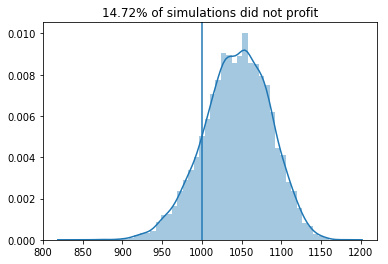

In [52]:
simulate(val_result)

#### 40 loans picked from 2563 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A']
- Expedted value >= -25

- Minimum predicted probability of loan repayment: 0.5

#### Range of results from 10000 simulations:

count    10000.000000
mean      1054.085755
std         22.601077
min        932.583268
25%       1040.404498
50%       1056.605680
75%       1070.960699
max       1104.561189



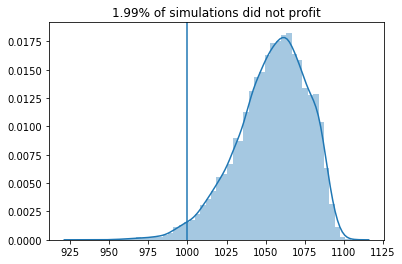

In [53]:
simulate(val_result, grades=['A'])

#### 40 loans picked from 2567 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= 28.727704784220705

- Minimum predicted probability of loan repayment: 0.5

#### Range of results from 10000 simulations:

count    10000.000000
mean      1089.976947
std         44.005142
min        892.113923
25%       1061.709720
50%       1092.534645
75%       1121.057585
max       1239.523699



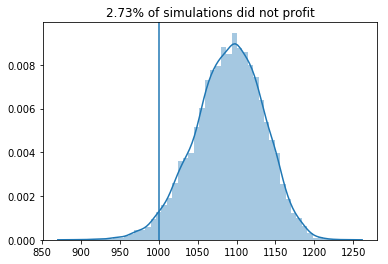

In [54]:
min_val = np.percentile(val_result['expected_value'], 80)
simulate(val_result, min_value=min_val)

#### 40 loans picked from 1806 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= 28.727704784220705

- Minimum predicted probability of loan repayment: 0.8

#### Range of results from 10000 simulations:

count    10000.000000
mean      1100.146958
std         36.022795
min        938.492123
25%       1076.846574
50%       1102.622874
75%       1125.624235
max       1205.568635



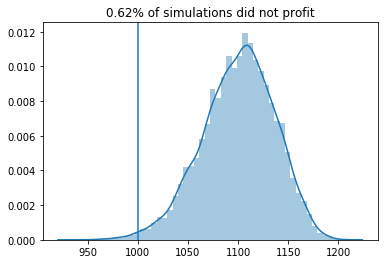

In [55]:
simulate(val_result, min_value=min_val, min_proba=.8)

#### 40 loans picked from 191 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['D']
- Expedted value >= 28.727704784220705

- Minimum predicted probability of loan repayment: 0.8

#### Range of results from 10000 simulations:

count    10000.000000
mean      1141.675473
std         35.669492
min        998.068514
25%       1117.909410
50%       1143.041962
75%       1166.891997
max       1246.462682



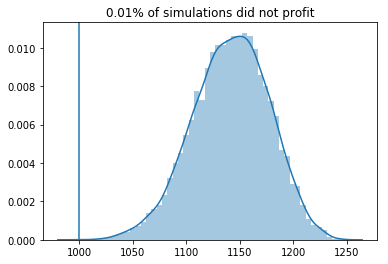

In [56]:
simulate(val_result, min_value=min_val, min_proba=.8, grades=['D'])

Test time!

In [57]:
y_pred_proba = model.predict_proba(X_test_t)[:, 1]
print(f'Test ROC AUC: {roc_auc_score(y_test, y_pred_proba)}')

Test ROC AUC: 0.6988592164632939


#### 40 loans picked from 1727 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= 28.713379813077267

- Minimum predicted probability of loan repayment: 0.8

#### Range of results from 10000 simulations:

count    10000.000000
mean      1098.240025
std         36.479925
min        936.787098
25%       1075.161783
50%       1101.108781
75%       1123.437650
max       1206.762374



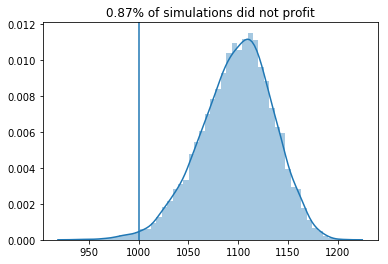

In [58]:
test_result = results(results_test, y_test, y_pred_proba)
min_val = np.percentile(test_result['expected_value'], 80)
simulate(test_result, min_value=min_val, min_proba=.8)

Shapley things.

In [59]:
test_result.head()

,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
107777,2017-07-01,C,0.265163,3.0,16.02,Charged Off,0.741103,39.042587,-25,22.462165,-18.370917
124003,2018-01-01,C,0.201669,5.0,12.62,Charged Off,0.643650,45.291596,-25,20.243214,-19.958264
101716,2013-12-01,A,1.126306,3.0,7.90,Fully Paid,0.948197,31.405401,-25,28.483426,3.157643
121932,2018-06-01,A,1.031113,3.0,6.83,Fully Paid,0.950424,30.480332,-25,27.729866,0.777829
101733,2015-12-01,A,1.076431,3.0,7.89,Fully Paid,0.939898,31.396670,-25,28.007115,1.910770


In [82]:
grades=['A', 'B', 'C', 'D']
start='2007-07-01'
end='2019-03-01'
min_proba=.5
min_value=-25

df = test_result.copy()

condition = (df['grade'].isin(grades) &
            (df['issue_d'] >= start) &
            (df['issue_d'] <= end) &
            (df['expected_value'] >= min_value) &
            (df['pred_proba'] >= min_proba))

possible = df[condition]
picks = possible.sample(40, random_state=42).copy()
pick = picks.index[3]
print(pick)
picks[picks.index == pick]
# picks

81108


,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
81108,2016-05-01,B,0.638719,5.0,8.39,Charged Off,0.814874,37.401248,-25,25.849184,-9.032021


In [83]:
data = X_test_trimmed[X_test_trimmed.index == pick]
data

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_up_manage,funded_amnt,home_ownership,inq_last_12m,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,revol_bal,revol_bal_joint,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_rev_hi_lim
81108,1.0,CA,36.0,70000.0,NaN,1810.0,19127.0,38.5,0.0,0.0,31.41,NaN,2983,10+ years,False,16.0,False,False,12000.0,RENT,0.0,245.57,8.39,5,2016,12000.0,3231.0,74.0,97.0,32.0,0.0,True,NaN,32.0,NaN,7.0,7.0,15.0,7.0,False,False,0.0,100.0,20.0,0.0,11973.0,NaN,2.1,60 months,23.0,False,0.0,89570.0,27.0,20606.0,31100.0,43800.0


In [84]:
data_ = processor.transform(data)
data_ = pd.DataFrame(data_)
data_.columns = data.columns

In [85]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_)
shap.force_plot(explainer.expected_value, shap_values, data_)

Use the class_weight parameter in sklearn.

In [65]:
def class_weighter(n_samples=1000, weights=(0.95, 0.5), class_sep=.8, class_weight=None):
    X, y = make_classification(n_samples=n_samples,
                               n_features=2,
                               n_informative=2,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2, 
                               n_clusters_per_class=2,
                               weights=weights,
                               class_sep=class_sep,
                               random_state=42)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,
                                                                          y,
                                                                          train_size=.8,
                                                                          val_size=.1,
                                                                          test_size=.1,
                                                                          random_state=42)
    
    
    model = LogisticRegression(solver='lbfgs',
                               class_weight=class_weight)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    nice_confusion(y_val, y_pred)
    
    plt.figure(figsize=(10, 6))
    plot_decision_regions(X_val, y_val, model, legend=0);

In [66]:
# class_weighter()

In [67]:
# class_weighter(class_weight='balanced')

In [68]:
# class_weighter(class_sep=.5, class_weight={0:1, 1:10})

In [69]:
# pipeline1 = make_pipeline(OrdinalEncoder(),
#                           XGBClassifier(early_stopping_rounds=50,
#                                        n_jobs=-1))
# pipeline1.fit(X_train, y_train)